# Problem B: Effective thermal conductivity of 2-phase materials
Predicting the effective thermal conductivity $k_{\text{eff}}$ of a two-phase composite material is a classical and practical problem in materials science. The goal is to estimate the bulk conductivity of a heterogeneous material made of two constituents with thermal conductivities $k_1$ and $k_2$. One efficient way to compute the effective thermal conductivity of given 2-phase materials is through numerical homogenization.

In numerical homogenization, we need to solve the steady-state heat equation on a representative volume element (RVE):
$$
-\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{2}
$$
With the following boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$

where $T(x,y)$ indicates the temperature  and $k(x,y)$ indicates thermal conductivity, which is defined piecewise:
$$
k(x,y)=
\begin{cases}
k_1=2.,\quad (x,y)\in\Omega_1\\
k_2=10.,\quad (x,y)\in\Omega_2
\end{cases}
$$
where $\Omega_1$, $\Omega_2$ denote the first phase region and the second phase region, respectively.

<!-- To compute the effective thermal conductivity in the $x$-direction, one can follow the steps:
- **Step 1:** Solve the following PDE:
    $$
    -\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{3}
    $$
  With boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$
- **Step 2:** Compute the **average heat flux:**
    $$
    <q> = \frac{1}{|\Omega|}\int_{\Omega}q~d\Omega
    $$
  where $q(x,y)=-k(x,y)\partial_x T$, and the **average temperature gradient:**
    $$
    <\partial_x T> =  \frac{1}{|\Omega|}\int_{\Omega}\partial_x T~d\Omega
    $$
- **Step 3:** Compute the **effective thermal conductivity (in $x$-direction):**
    $$
    k_{eff} = -\frac{<q>}{<\partial_x T>} = \frac{<k(x,y)\partial_x T>}{<\partial_x T>}
    $$ -->

## Task: predicting the temperature field $T(x,y)$ given 2-phase material $k(x,y)$
In this task, we have collected many materials $k(x,y)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding temperature field $T(x,y)$ through solving the PDE problem $(2)$ with high-precision FEM method. Now, we hope to make a fast prediction of the temperature field $T(x,y)$ (therefore, a fast prediction of the effective conductivity) of a group of materials that are sampled from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{T^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{T^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|T^{(j)}_{pred}(x_i)-T^{(j)}_{true}(x_i)|^2}{\sum_i|T^{(j)}_{true}(x_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the material thermal conductivity, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```EffectiveConductivity.h5```:
- ```k_train```: size(1000, 36, 36), the collected materials (a $36\times 36$ matrix represents each material)
- ```T_train```: size(1000, 36, 36), the collected temperature field (computed on a $36\times 36$ regular mesh)
- ```k_test```: the materials that we are going to predict their corresponding temperature field (Should not be used for training)
- ```T_test```: the ground truth reference of the temperature field (Should not be used for training)
- ```X```: size(36, 36), the $x$-coordiante of locations where the temperature field computed
- ```Y```: size(36, 36), the $y$-coordiante of locations where the temperature field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

Using device: cuda
<KeysViewHDF5 ['T_test', 'T_train', 'X', 'Y', 'dTx_test', 'dTx_train', 'k_test', 'k_train']>
The shape of X: torch.Size([36, 36]) The shape of Y: torch.Size([36, 36])
The shape of k_train: torch.Size([1000, 36, 36])
The shape of T_train: torch.Size([1000, 36, 36])
The shape of k_test: torch.Size([200, 36, 36])
The shape of T_test: torch.Size([200, 36, 36])


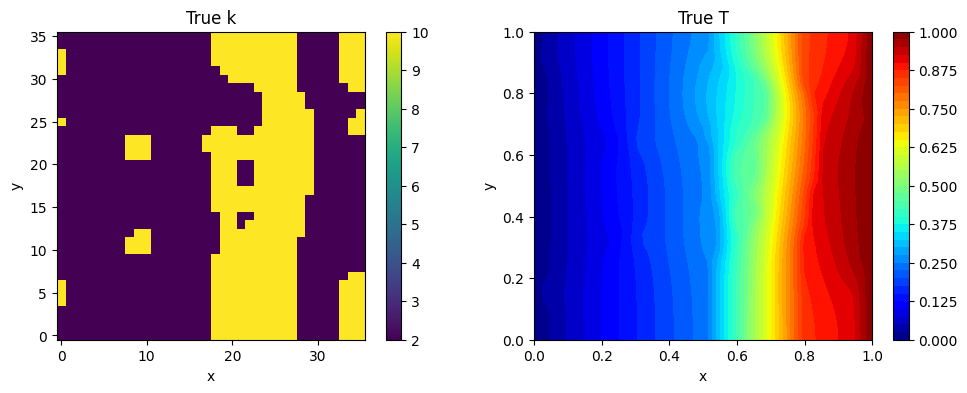

In [1]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
dtype = torch.float32
torch.cuda.is_available()

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

######################################
# Load training data
######################################
filepath = '/kaggle/input/effectiveconductivity-h5/EffectiveConductivity.h5'
with h5py.File(filepath, 'r') as data:
    print(data.keys())
    k_train = torch.tensor(np.array(data["k_train"]), dtype=dtype); k_train[k_train==0]=2.; k_train[k_train==1]=10.
    T_train = torch.tensor(np.array(data["T_train"]), dtype=dtype)
    k_test = torch.tensor(np.array(data["k_test"]), dtype=dtype); k_test[k_test==0]=2.; k_test[k_test==1]=10.
    T_test =torch.tensor( np.array(data["T_test"]), dtype=dtype)
    # The coordinates
    X = torch.tensor(np.array(data['X']), dtype=dtype)
    Y = torch.tensor(np.array(data['Y']), dtype=dtype)
print('The shape of X:', X.shape, 'The shape of Y:', Y.shape)
print('The shape of k_train:', k_train.shape)
print('The shape of T_train:', T_train.shape)
print('The shape of k_test:', k_test.shape)
print('The shape of T_test:', T_test.shape)

####### Visualize the training data
k_show, T_show = k_train[0], T_train[0]
#
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
cntr0 = axs.flat[:][0].imshow(k_show, origin='lower')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True k')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
cntr1 = axs.flat[:][1].contourf(X, Y, T_show, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('True T')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
plt.show()

In [2]:
# Combine the input coordinates and k(x) -> kx_train = [k(x)], x, y]
ndata_train = k_train.shape[0]
ndata_test = k_test.shape[0]

# compute coodinates: Input X, Y -> Output: Each Point in the net has two coordinates grid_xy = 36 x 36 x 2 (X,Y)
grid_xy = torch.stack([X, Y], dim =-1) # torch.Size([36, 36, 2])
x_train = grid_xy.unsqueeze(0).repeat(ndata_train, 1, 1, 1) # torch.Size([1000, 36, 36, 2])
x_test = grid_xy.unsqueeze(0).repeat(ndata_test, 1, 1, 1)

k_train_reshaped = k_train.unsqueeze(-1) # torch.Size([1000, 36, 36, 1])
k_test_reshaped = k_test.unsqueeze(-1)

# kx: thermal conductivity + coordinates
kx_train = torch.cat([k_train_reshaped, x_train], dim=-1) # torch.Size([1000, 36, 36, 3])
kx_test = torch.cat([k_test_reshaped, x_test], dim=-1)

print('The shape of grid_xy:', grid_xy.shape)
print('The shape of x_train:', x_train.shape)
print('The shape of k_train:', k_train.shape)
print('The shape of kx_train:', kx_train.shape)
T_train = T_train.unsqueeze(-1)
T_test = T_test.unsqueeze(-1)
print('The shape of T_train:', T_train.shape)

The shape of grid_xy: torch.Size([36, 36, 2])
The shape of x_train: torch.Size([1000, 36, 36, 2])
The shape of k_train: torch.Size([1000, 36, 36])
The shape of kx_train: torch.Size([1000, 36, 36, 3])
The shape of T_train: torch.Size([1000, 36, 36, 1])


In [3]:
from torch.utils.data import random_split, TensorDataset

dataset = TensorDataset(kx_train, T_train)
train_set, val_set = random_split(dataset, [800, 200])

# Optional: wieder in Tensoren umwandeln
kx_train, T_train = train_set[:][0], train_set[:][1]
kx_train_val, T_train_val = val_set[:][0], val_set[:][1]

print(kx_train.shape)
print(T_train.shape)

print(kx_train_val.shape)
print(T_train_val.shape)

torch.Size([800, 36, 36, 3])
torch.Size([800, 36, 36, 1])
torch.Size([200, 36, 36, 3])
torch.Size([200, 36, 36, 1])


In [4]:
import torch.nn as nn

class SpectralConv2d(nn.Module):
    def __init__(self, in_size, out_size, modes1, modes2, dtype):
        super(SpectralConv2d, self).__init__()

        self.in_size = in_size
        self.out_size = out_size
        self.modes1 = modes1
        self.modes2 = modes2


        self.scale = 1./(in_size * out_size)

        if (dtype is None) or (dtype==torch.float32):
            ctype = torch.complex64
        elif (dtype==torch.float64):
            ctype = torch.complex128
        else:
            raise TypeError(f'No such data type.')


        self.weight1 = nn.Parameter(self.scale * torch.rand(in_size, out_size, self.modes1, self.modes2, dtype=ctype)) # lower frequencies
        self.weight2 = nn.Parameter(self.scale * torch.rand(in_size, out_size, self.modes1, self.modes2, dtype=ctype)) # high frequencies


    # Helper function to multiply matrices
    def compl_mul_2d(self, input, weights):
        '''Complex multiplication: (batch_size, in_size, m1, m2) * (in_size, out_size, m1, m2) -> (batch_size, out_size, m1, m2)
        '''
        return torch.einsum('bixy,ioxy->boxy', input, weights)



    def forward(self, x):


      batch_size = x.shape[0]

      x_ft = torch.fft.rfft2(x)

      out_ft = torch.zeros(batch_size, self.out_size, x.size(-2), x.size(-1)//2+1,device=x.device, dtype=torch.cfloat)

      out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul_2d(x_ft[:, :, :self.modes1, :self.modes2], self.weight1)
      out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul_2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weight2)

      x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1))) # size(batch_size, out_size, mx_size, my_size)

      return x



class FNO2d(nn.Module):

    def __init__(self, in_size:int, out_size:int, modes1:int, modes2:int,
                 hidden_list:list[int], dtype=None):
        super(FNO2d, self).__init__()
        self.hidden_list = hidden_list
        # Activation
        self.activation = nn.ReLU()
        # The input layer:
        self.fc_in = nn.Linear(in_size, hidden_list[0], dtype=dtype)
        # The hidden layer
        conv_net, w_net = [], []
        self.hidden_in = hidden_list[0]
        for hidden in hidden_list:
            conv_net.append(SpectralConv2d(self.hidden_in, hidden, modes1, modes2, dtype))
            w_net.append(nn.Conv1d(self.hidden_in, hidden, 1, dtype=dtype))
            self.hidden_in =  hidden
        self.spectral_conv = nn.Sequential(*conv_net)
        self.weight_conv = nn.Sequential(*w_net)
        # The output layer
        self.fc_out0 = nn.Linear(self.hidden_in, 128, dtype=dtype)
        self.fc_out1 = nn.Linear(128, out_size, dtype=dtype)


    def forward(self, kx):

          batch_size = kx.shape[0]

          mx_size, my_size = kx.shape[1], kx.shape[2]

          kx = self.fc_in(kx)
          kx = kx.permute(0, 3, 1, 2)

          # The spectral conv layer
          for conv, weight, hidden_size in zip(self.spectral_conv, self.weight_conv, self.hidden_list):
            kx1 = conv(kx)   # size(b, hidden_size, my_size, mx_size)
            kx2 = weight(kx.view(batch_size, hidden_size, -1)).view(batch_size, hidden_size, mx_size, my_size)
            kx = self.activation(kx1+kx2)
          # The output layer: size(batch_size, hidden_size, my_size, mx_size) -> size(batch_size, my_size, mx_size, out_size)
          kx = kx.permute(0, 2, 3, 1)
          kx = self.fc_out0(kx)
          kx = self.activation(kx)

          return self.fc_out1(kx)

# defines number of considered fourier components
mode1 = 11 # first 8 in vertical direction
mode2 = 11 # first 8 in horizontal direction

hidden_list = [256, 256, 256]
model_T = FNO2d(kx_train.shape[-1], T_train.shape[-1], mode1, mode2, hidden_list).to(device)
################## Find total trainable parameters
total_trainable_params = sum(p.numel() for p in model_T.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

47,810,561 training parameters.


In [5]:
print('Input size:',kx_train.shape[-1])
print('Output size:',T_train.shape[-1])

Input size: 3
Output size: 1


class LossClass(object):

    def __init__(self, T_model):
        self.device = device
        self.T_model = T_model

    def loss_data(self, kx_batch, T_batch):
        '''loss term'''
        batch_size = T_batch.shape[0]
        kx = kx_batch.to(self.device)
        T = T_batch.to(self.device)
        #
        T_pred = self.T_model(kx)
        loss = torch.norm(T.reshape(batch_size, -1)-T_pred.reshape(batch_size, -1), 2, 1)
        loss = torch.mean(loss)

        return loss

In [6]:
class LossClass(object):

    def __init__(self, T_model):
        self.device = device
        self.T_model = T_model

    def loss_data(self, kx_batch, T_batch):
        '''loss term'''
        batch_size = T_batch.shape[0]
        kx = kx_batch.to(self.device)
        T = T_batch.to(self.device)
        #
        T_pred = self.T_model(kx)
        loss = torch.norm(T.reshape(batch_size, -1)-T_pred.reshape(batch_size, -1), 2, 1)
        loss = torch.mean(loss)

        return loss

    def get_error(self, x_test, u_test):
        '''Compute the L^2 relative error when testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.T_model(x_test)

        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))

In [7]:
from torch.utils.data import Dataset, DataLoader
############# Define your own dataset
class MyDataset(Dataset):

    def __init__(self, kx:torch.tensor, T:torch.tensor):
        '''
        Input:
            ax: size(batch_size, a_size+x_size)
            u: size(batch_size, u_size)
        '''
        self.kx = kx
        self.T = T

    def __getitem__(self, index):
        return self.kx[index], self.T[index]

    def __len__(self):
        return self.kx.shape[0]

##############
train_loader = DataLoader(MyDataset(kx_train, T_train), batch_size=50, shuffle=True)
val_loader = DataLoader(MyDataset(kx_train_val, T_train_val), batch_size=50, shuffle=True)
for kx_batch, T_batch in train_loader:
    print('kx_batch shape:', kx_batch.shape, 'T_batch shape:', T_batch.shape)
print()
for kx_batch, T_batch in val_loader:
    print('kx_batch shape:', kx_batch.shape, 'T_batch shape:', T_batch.shape) 

kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3]) T_batch shape: torch.Size([50, 36, 36, 1])
kx_batch shape: torch.Size([50, 36, 36, 3])

In [8]:
from tqdm import trange
import time
############ Training setups
epochs = 2000
lr = 1e-3
optimizer = torch.optim.Adam(params=model_T.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
loss_list = []

best_model = None
best_val_loss = 1e6
early_stopping = 30
min_delta = 1e-4
early_stopping_epoch = 0

loss_list = []
val_loss_list = []

############ The training process
t0 = time.time()
for epoch in trange(epochs):

    model_T.train()

    train_loss_per_epoch = 0

    for kx_batch, T_batch in train_loader:

      optimizer.zero_grad()
      lossClass = LossClass(model_T)
      loss_train = lossClass.loss_data(kx_batch, T_batch)

      train_loss_per_epoch += loss_train.item()
      
      loss_train.backward()
      optimizer.step()
      scheduler.step()

    loss_list.append(train_loss_per_epoch/len(train_loader))
    if (epoch+1)%100==0:
        print(f'\n Epoch:{epoch}, The training loss is:{loss_list[-1]}')

    model_T.eval()

    #
    with torch.no_grad():

      val_loss_per_epoch = 0

      for kx_batch, T_batch in val_loader:

        loss_val = lossClass.loss_data(kx_batch, T_batch)
        val_loss_per_epoch += loss_val.item()

      val_loss_list.append(val_loss_per_epoch/len(val_loader))
      if (epoch+1)%100==0:
          print(f'\n Epoch:{epoch}, The validation loss is:{val_loss_list[-1]}')  

      early_stopping_epoch += 1
      if val_loss_per_epoch <= best_val_loss:
        best_val_loss = val_loss_per_epoch
        best_model_weights = model_T.state_dict() # save the weights
        best_epoch = epoch
        early_stopping_epoch = 0 # Rest
      if early_stopping_epoch > early_stopping:
        break


    

    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()},The validation loss is: {loss_val.item()} ,learning rate: lr: {scheduler.optimizer.param_groups[0]["lr"]}')
print('The consuming time is:', time.time()-t0)
print(f"Loading model from epoch {best_epoch}")
model_T.load_state_dict(best_model_weights)

  5%|▍         | 99/2000 [06:06<1:57:44,  3.72s/it]


 Epoch:99, The training loss is:0.09566492214798927


  5%|▌         | 100/2000 [06:10<1:57:38,  3.72s/it]


 Epoch:99, The validation loss is:0.20095452293753624
Epoch:99, The loss is:0.09479182213544846,The validation loss is: 0.19291377067565918 ,learning rate: lr: 0.000125


 10%|▉         | 199/2000 [12:17<1:51:18,  3.71s/it]


 Epoch:199, The training loss is:0.06153428973630071


 10%|█         | 200/2000 [12:21<1:51:15,  3.71s/it]


 Epoch:199, The validation loss is:0.1899280957877636
Epoch:199, The loss is:0.06252246350049973,The validation loss is: 0.18009772896766663 ,learning rate: lr: 1.5625e-05


 15%|█▍        | 299/2000 [18:27<1:44:54,  3.70s/it]


 Epoch:299, The training loss is:0.05615029623731971


 15%|█▌        | 300/2000 [18:31<1:44:49,  3.70s/it]


 Epoch:299, The validation loss is:0.18872371315956116
Epoch:299, The loss is:0.05635892599821091,The validation loss is: 0.19600646197795868 ,learning rate: lr: 1.953125e-06


 20%|█▉        | 399/2000 [24:38<1:38:45,  3.70s/it]


 Epoch:399, The training loss is:0.055488217156380415


 20%|██        | 400/2000 [24:41<1:38:42,  3.70s/it]


 Epoch:399, The validation loss is:0.18855595216155052
Epoch:399, The loss is:0.056510090827941895,The validation loss is: 0.18774524331092834 ,learning rate: lr: 2.44140625e-07


 22%|██▏       | 430/2000 [26:36<1:37:09,  3.71s/it]

The consuming time is: 1596.640179157257
Loading model from epoch 399


<All keys matched successfully>

The shape of k_test: torch.Size([200, 36, 36])
The shape of T_test: torch.Size([200, 36, 36, 1])
The shape of x_test: torch.Size([200, 36, 36, 2])
The shape of u_pred: torch.Size([200, 36, 36, 1])
The l2 error: tensor([0.0164, 0.0101, 0.0125, 0.0079, 0.0118, 0.0062, 0.0048, 0.0073, 0.0076,
        0.0063, 0.0068, 0.0097, 0.0093, 0.0095, 0.0089, 0.0085, 0.0080, 0.0054,
        0.0080, 0.0088, 0.0064, 0.0128, 0.0103, 0.0061, 0.0110, 0.0066, 0.0062,
        0.0078, 0.0099, 0.0072, 0.0074, 0.0122, 0.0049, 0.0070, 0.0111, 0.0135,
        0.0162, 0.0052, 0.0166, 0.0117, 0.0105, 0.0049, 0.0094, 0.0049, 0.0085,
        0.0084, 0.0069, 0.0081, 0.0103, 0.0060, 0.0069, 0.0052, 0.0060, 0.0109,
        0.0150, 0.0198, 0.0129, 0.0090, 0.0076, 0.0120, 0.0063, 0.0071, 0.0047,
        0.0088, 0.0073, 0.0127, 0.0075, 0.0074, 0.0093, 0.0065, 0.0065, 0.0082,
        0.0107, 0.0066, 0.0083, 0.0100, 0.0063, 0.0079, 0.0108, 0.0096, 0.0077,
        0.0179, 0.0064, 0.0106, 0.0103, 0.0074, 0.0102, 0.0058, 0.010

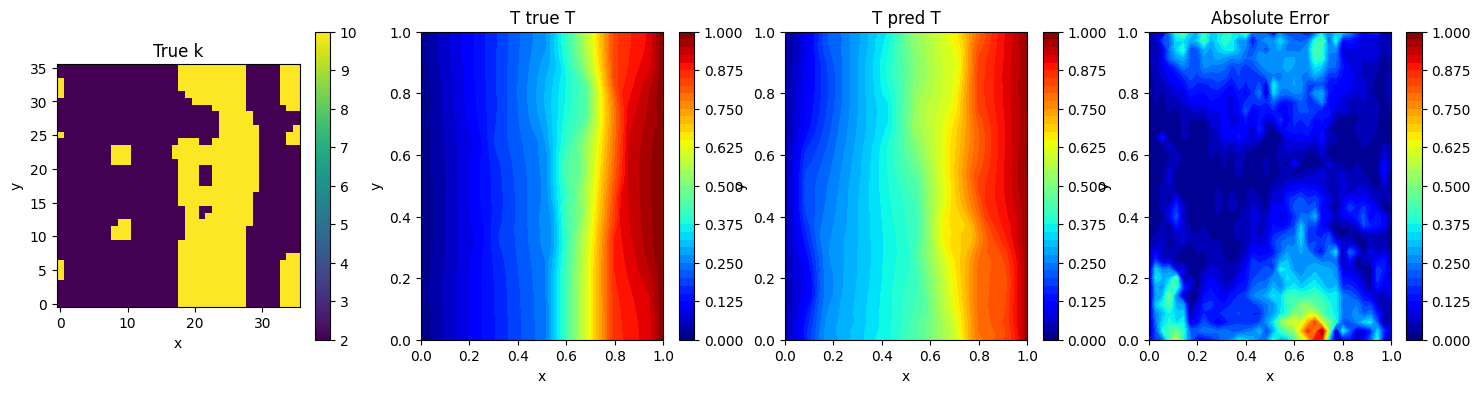

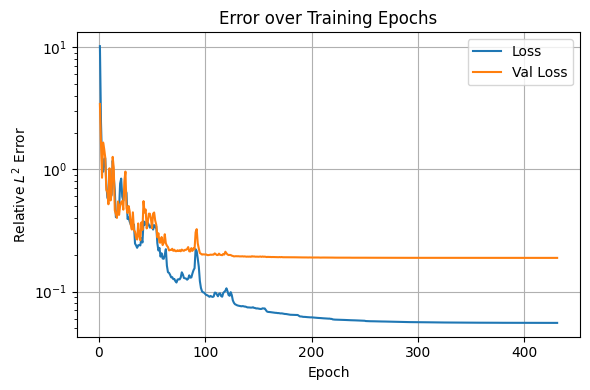

In [9]:
print('The shape of k_test:', k_test.shape)
print('The shape of T_test:', T_test.shape)
print('The shape of x_test:', x_test.shape)

#######################################
# The L2 relative error
#######################################
def L2_error(T, T_pred, ndata=200):
    ''' '''
    l2 = torch.norm(T.reshape(ndata,-1)-T_pred.reshape(ndata,-1), 2, 1) / torch.norm(T.reshape(ndata, -1), 2, 1)
    return l2

T_test_pred = model_T(kx_test.to(device)).detach().cpu()
print('The shape of u_pred:', T_test_pred.shape)
l2_err = L2_error(T_test, T_test_pred)
print('The l2 error:', l2_err)
print('The average l2 error:', torch.mean(l2_err))

####### Visualize the training data
T_true, T_pred = T_test[0], T_test_pred[0]
T_pred = T_pred.squeeze(-1)
T_true = T_true.squeeze(-1)

#
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
#
cntr0 = axs.flat[:][0].imshow(k_show, origin='lower')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True k')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
cntr1 = axs.flat[:][1].contourf(X, Y, T_show, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('T true T')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
cntr2 = axs.flat[:][2].contourf(X, Y, T_pred, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][2])
axs.flat[:][2].set_title('T pred T')
axs.flat[:][2].set_xlabel('x')
axs.flat[:][2].set_ylabel('y')
#

cntr3 = axs.flat[:][3].contourf(X, Y, np.abs(T_true - T_pred), levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][3])
axs.flat[:][3].set_title('Absolute Error')
axs.flat[:][3].set_xlabel('x')
axs.flat[:][3].set_ylabel('y')
plt.show()


# Plot training error over epochs
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, epoch+2), loss_list, label='Loss')
plt.plot(np.arange(1, epoch+2), val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Relative $L^2$ Error')
plt.title('Error over Training Epochs')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
